In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create metro network

#### (1) Load data

In [2]:
from codes.utils.load_data.load_data_metro import load_metro_station_list_v1, preprocess_metro_station

excel_path = 'station_line_list/station_list.xlsx'
# Load metro station data
data = load_metro_station_list_v1(excel_path)
# Preprocess metro station data
data = preprocess_metro_station(data, time_status='current')

# make sure data type is string for saving graph
data = data.assign(line_cycle = lambda x : x['cycle'].map({'T' : True, 'F' : False})) \
           .assign(opening_date = lambda x : x['opening_date'].dt.strftime('%Y-%m-%d')) \
           .assign(station_id = lambda x : range(len(x))) \
           .rename(columns = {'X':'x', 'Y':'y', 'LATITUDE':'lat', 'LONGITUDE':'lon'})
print('\nShape of data:', data.shape,
      '\nColumns:', data.columns.to_list())

Loading data...: 14it [00:01,  9.29it/s]


Shape of data: (215, 25) 
Columns: ['no', 'station_code', 'station_name', 'build_date', 'opening_date', 'closed_date', 'SEARCHVAL', 'BLK_NO', 'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'x', 'y', 'lat', 'lon', 'sheet_name', 'line_name', 'line_code', 'line_type', 'cycle', 'line_color', 'name_id', 'line_cycle', 'station_id']



C:\Users\Wei Zhou\Documents\zhouwei file\Github-Project\VeDa-Public-Transit-Network\codes\utils\load_data\load_data_metro.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['closed_date'] = data['closed_date'].infer_objects(copy=True).fillna(pd.Timestamp.max)


#### (2) Create metro line

In [3]:
from codes.utils.graph_network.create_metro_graph import create_graph_from_dataframe, graph_add_transfer_edges_from_dataframe
from codes.utils.graph_network.graph_statistic import print_graph_basic_information

# attributes
node_id_col = 'station_id'
node_attr = ['station_code', 'station_name', 'name_id', 'line_color', 'opening_date',
             'x', 'y', 'lat', 'lon',
             'line_name', 'line_code', 'line_color', 'line_type', 'cycle']
edge_attr = ['line_name', 'line_code', 'line_color', 'line_type', 'cycle']


graph = create_graph_from_dataframe(
    data,
    node_id_col = node_id_col,
    order_col = 'no',
    mline_id_col = 'sheet_name',
    mline_cycle_col = 'line_cycle',
    node_attr_list = node_attr,
    edge_attr_list = edge_attr,
    space = 'l')
# add access_type
nx.set_edge_attributes(graph, values={edge : {'travel_type' : 'in-transit'} for edge in graph.edges()})

print_graph_basic_information(graph)

Creating graph...: 100%|██████████| 14/14 [00:00<00:00, 71.27it/s]


Directed: False 
Number of nodes: 215 
Number of edges: 206


#### (3) Add transfer information

In [4]:
# Transfer station
# Extract transfer stations
transfer_stn = data['name_id'].value_counts()
transfer_stn = transfer_stn[transfer_stn > 1].index.tolist()
print('\nNumber of stations:', data['name_id'].nunique(),
      '\nNumber of transfer stations:', len(transfer_stn))

transfer_stn = data.query('name_id in @transfer_stn') \
    .sort_values(['line_name', 'no']) \
    .reset_index(drop=True)


Number of stations: 178 
Number of transfer stations: 30


In [5]:
# add transfer edge
# parameters:
#   node_id_col: the station unique id columns in "transfer_stn"
#   transfer_name_col: the column indicating the transfer station, i.e., the same value in "transfer_name_col" representing the transfer station
#   merge_transfer_node (bool): whether merge the transfer station into one node
graph = graph_add_transfer_edges_from_dataframe(
    graph, transfer_stn,
    node_id_col = 'station_id',
    transfer_name_col = 'name_id',
    attr_list_unique = node_attr,
    attr_list_merged = None,
    merge_transfer_node = False)
# print_graph_basic_information(graph)
# add edge attributes for transfer edge
nx.set_edge_attributes(graph, values={edge : {'travel_type' : 'transfer'}
                                      for edge in graph.edges()
                                      if not('travel_type' in graph.get_edge_data(edge[0], edge[1]).keys())})

In [6]:
# save graph
# path ='sg_metro_network_202406.gexf'
# nx.write_gexf(graph, path)
# path ='sg_metro_network_202406.gml'
# nx.write_gml(graph, path)

#### (4) Plot metro network

<Axes: >

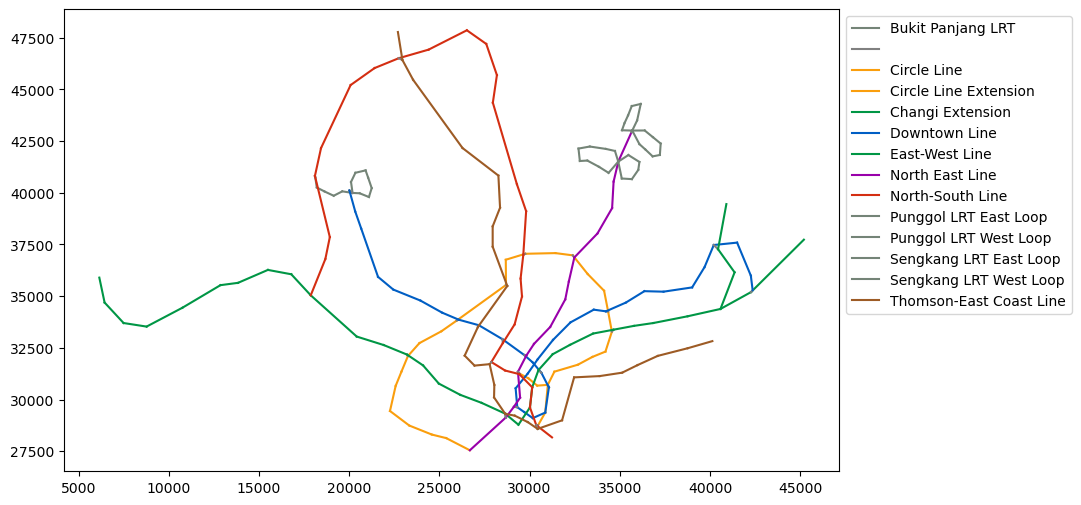

In [7]:
from codes.utils.plot.plot_metro_network import plot_geographical_graph_edge

# graph.remove_edges_from([edge for edge in graph.edges() if graph[edge[0]][edge[1]]['travel_type'] == 'in-transit'])
# nx.to_pandas_edgelist(graph)

# plot geographical graph
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_geographical_graph_edge(
    graph,
    x_col = 'x', y_col = 'y',
    mline_label = 'line_name', 
    mline_color = 'line_color',
    sort_legend = None,
    ax = ax)

# 2. Add access links

In [8]:
import re

path = r'C:\Users\Wei Zhou\Downloads\TrainStationExit.zip!TrainStationExit\Train_Station_Exit_Layer.shp'
path = path.replace('\\', '/')
stn_exit = gpd.read_file(path)
print('\nShape of data:', stn_exit.shape,
      '\nCRS:', stn_exit.crs)

stn_exit = stn_exit.to_crs('EPSG:4326') \
    .assign(lon = lambda g : g.geometry.x,
            lat = lambda g : g.geometry.y) \
    .to_crs('EPSG:3414') \
    .assign(x = lambda g : g.geometry.x,
            y = lambda g : g.geometry.y)

# add node unique id
stn_exit['node_id'] = [f'E{i}' for i in range(len(stn_exit))]
# add station name id
stn_exit['name_id'] = stn_exit['stn_name'].str.replace(re.compile('\W'), '', regex=True).str.lower()
stn_exit['name_id'] = stn_exit['name_id'].map(lambda x : x.removesuffix('mrtstation').removesuffix('lrtstation'))


Shape of data: (593, 3) 
CRS: PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",1.36666666666667],PARAMETER["central_meridian",103.833333333333],PARAMETER["scale_factor",1],PARAMETER["false_easting",28001.642],PARAMETER["false_northing",38744.572],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [9]:
# relabel station nodes
graph = nx.relabel_nodes(graph, mapping={node : f'S{node}' for node in graph.nodes()})

# add node
from codes.utils.graph_network.create_metro_graph import graph_add_nodes_from_dataframe
graph = graph_add_nodes_from_dataframe(
    graph,
    data = stn_exit,
    node_id_col = 'node_id',
    attr_list = ['name_id', 'x', 'y', 'lon', 'lat', 'exit_code'])

# add edges
for node in graph.nodes(data=True):

    stn_node_id = node[0]
    stn_name_id = node[1]['name_id']

    exit_node = stn_exit.query('name_id == @stn_name_id')

    if len(exit_node) == 0:
        print('Not found exit for station:', stn_name_id)
    else:
        for exit_node_id in exit_node['node_id'].to_list():
            # print(stn_node_id, exit_node_id)
            graph.add_edge(stn_node_id, exit_node_id, travel_type='access')

# print information
print_graph_basic_information(graph)

In [10]:
# # save graph
# path ='sg_metro_network_with_exit_202406.gexf'
# nx.write_gexf(graph, path)
# path ='sg_metro_network_with_exit_202406.gml'
# nx.write_gml(graph, path)